# RFTM

- [arXiv](https://arxiv.org/help/api/user-manual)


## Specify the place to search

| prefix |	explanation |
|--------|--------------|
| ti     | 	Title |
| au 	 | Author |
| abs    |	Abstract |
| co     | 	Comment |
| jr 	 | Journal Reference |
| cat    | 	Subject Category |
| rn     | 	Report Number |
| id 	 | Id (use id_list instead) |
| all    | 	All of the above | 

# Try some examples

- [click](http://export.arxiv.org/api/query?search_query=all:"machine learning"+OR+networkd&start=0&max_results=3)

See that you can range over your query

- [start 0](http://export.arxiv.org/api/query?search_query=all:"machine learning"&start=0&max_results=2)
- [start 1](http://export.arxiv.org/api/query?search_query=all:"machine learning"&start=1&max_results=1)

Sorting results:

- [NEW](http://export.arxiv.org/api/query?search_query=all:machine learning&sortBy=submittedDate&sortOrder=descending&start=0&maxResults=10)
- [OLD](http://export.arxiv.org/api/query?search_query=all:machine learning&sortBy=submittedDate&sortOrder=ascending&start=0&maxResults=10)

In [87]:
def create_query(search_query, where="all", start=0, max_results=10, sortBy="submittedDate", sortOrder="descending"):
    """
    
    where: all | tl | cat | ... see the documentation
    maxResults: default 10, max 30000
    sortBy: relevance | lastUpdatedDate | submittedDate
    sortOrder: ascending | descending
    """
    
    return "http://export.arxiv.org/api/query?search_query={}:{}&sortBy={}&sortOrder={}&start={}&max_results={}".format(where, 
                                                                                search_query, 
                                                                                sortBy, 
                                                                                sortOrder,
                                                                                start,
                                                                                max_results)

In [88]:
create_query("machine learning")

'http://export.arxiv.org/api/query?search_query=all:machine learning&sortBy=submittedDate&sortOrder=descending&start=0&max_results=10'

# Find a problem to solve

Our goal is to study the evolution of a topic

- What are the relative keywords
- What are the major authors
- How does it evolve along time
- anything not coffee

In [171]:
import requests
import re
import time
from time import mktime
import datetime


import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

In [138]:
my_url = create_query("machine learning", max_results=2)
print(my_url)
get_response = requests.get(my_url)

http://export.arxiv.org/api/query?search_query=all:machine learning&sortBy=submittedDate&sortOrder=descending&start=0&max_results=2


In [139]:
Result = get_response.content.decode() 
print(Result)

<?xml version="1.0" encoding="UTF-8"?>
<feed xmlns="http://www.w3.org/2005/Atom">
  <link href="http://arxiv.org/api/query?search_query%3Dall%3Amachine%20learning%26id_list%3D%26start%3D0%26max_results%3D2" rel="self" type="application/atom+xml"/>
  <title type="html">ArXiv Query: search_query=all:machine learning&amp;id_list=&amp;start=0&amp;max_results=2</title>
  <id>http://arxiv.org/api/8xw5DtHrC6jdzWr/S+7l3RKB7mI</id>
  <updated>2017-09-04T00:00:00-04:00</updated>
  <opensearch:totalResults xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">43145</opensearch:totalResults>
  <opensearch:startIndex xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">0</opensearch:startIndex>
  <opensearch:itemsPerPage xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">2</opensearch:itemsPerPage>
  <entry>
    <id>http://arxiv.org/abs/1709.00407v1</id>
    <updated>2017-09-01T18:25:02Z</updated>
    <published>2017-09-01T18:25:02Z</published>
    <title>Estimating Mixed Memberships with

## RTFM: keywords

- id
- maxResult (available)
- updated
- published
- title
- author
- name
- category
- summary
- entry


In [129]:
ID_MAIN                = '<id>http://arxiv.org.api/[a-zA-Z0-9 .!:;,?]+</id>'
OPENSEARCH_TOT_RESULTS = '<opensearch:totalResults xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">[0-9]+</opensearch:totalResults>'
UPDATED                = "<updated>[0-9\-A-Z:]+</updated>"
PUBLISHED              = "<published>[0-9\-A-Z:]+</published>"
TITLE                  = "<title>[a-zA-Z0-9 .!:;,?]+</title>"
AUTHOR_NAME            = "<author>[ \n]+<name>[a-zA-Z0-9 .!:;,?]+</name>[ \n]+</author>"
CATEGORY               = '<category term=[a-zA-Z0-9 .!:;,?"]+ scheme="http://arxiv.org/schemas/atom"/>'


In [137]:
print(PUBLISHED[11:-12])
print(UPDATED[9:-10])
print(TITLE[7:-8])
print(CATEGORY[15:-41])

[0-9\-A-Z:]+
[0-9\-A-Z:]+
[a-zA-Z0-9 .!:;,?]+
[a-zA-Z0-9 .!:;,?"]+


In [152]:
re_id        = re.compile(ID_MAIN)
re_max       = re.compile(OPENSEARCH_TOT_RESULTS)
re_updated   = re.compile(UPDATED)
re_published = re.compile(PUBLISHED)
re_title     = re.compile(TITLE)
re_author    = re.compile(AUTHOR_NAME) # unsafe
re_category  = re.compile(CATEGORY) 


re_entry_start = re.compile('<entry>')
re_entry_end   = re.compile('</entry>')

def extract_entry(rst):
    lst = []
    for g1, g2 in zip(re_entry_start.finditer(rst), re_entry_end.finditer(rst)):
        lst.append(rst[g1.end(): g2.start()])
    return lst

re_summary_start = re.compile('<summary>')
re_summary_end   = re.compile('</summary>')

def extract_summary(rst):
    lst = []
    for g1, g2 in zip(re_summary_start.finditer(rst), re_summary_end.finditer(rst)):
        lst.append(rst[g1.end(): g2.start()])
    return lst

In [176]:
def get_id_main(lst):
    return list(map(lambda x: x[25:-6], lst))

def get_max_results_possible(lst):
    return list(map(lambda x: int(x[81:-27]), lst))

def get_published(lst):
    return list(map(lambda x: datetime.datetime.strptime(x[11:-12], "%Y-%m-%dT%H:%M:%SZ"), lst))

def get_title(lst):
    return list(map(lambda x: x[7:-8], lst))

def get_author(lst):
    return list(map(lambda x: x[21:-21], lst))

def get_category(lst):
    return list(map(lambda x: x[15:-41], lst))


# Ask the good questions

## What is the trend for ...

### Specifying the keywords

In [233]:
SEARCHING_FOR = "neural networks"

my_url = create_query(SEARCHING_FOR, max_results=1)
print(my_url)

get_response = requests.get(my_url)
Result = get_response.content.decode() 
print(Result)


http://export.arxiv.org/api/query?search_query=all:neural networks&sortBy=submittedDate&sortOrder=descending&start=0&max_results=1
<?xml version="1.0" encoding="UTF-8"?>
<feed xmlns="http://www.w3.org/2005/Atom">
  <link href="http://arxiv.org/api/query?search_query%3Dall%3Aneural%20networks%26id_list%3D%26start%3D0%26max_results%3D1" rel="self" type="application/atom+xml"/>
  <title type="html">ArXiv Query: search_query=all:neural networks&amp;id_list=&amp;start=0&amp;max_results=1</title>
  <id>http://arxiv.org/api/npmA5soEDvRFsGSQgtv8Ha1cVZw</id>
  <updated>2017-09-04T00:00:00-04:00</updated>
  <opensearch:totalResults xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">80970</opensearch:totalResults>
  <opensearch:startIndex xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">0</opensearch:startIndex>
  <opensearch:itemsPerPage xmlns:opensearch="http://a9.com/-/spec/opensearch/1.1/">1</opensearch:itemsPerPage>
  <entry>
    <id>http://arxiv.org/abs/1709.00407v1</id>
    <up

For "neural networks", you will see a crisis on it ...


### Counting the max occurences

In [234]:
lst_nmax = re_max.findall(Result)
lst_nmax = get_max_results_possible(lst_nmax)
print(lst_nmax)

nmax = lst_nmax[0] if lst_nmax != [] else 0
print("Number of results: {}".format(nmax))

[8097]
Number of results: 8097


### Searching for trends of publication

In [235]:
STEP_SIZE = 100
nsteps = int(nmax/STEP_SIZE) + 1

print("Number of steps to perform: {}; size: {}".format(nsteps, STEP_SIZE))

lst_date = []

for i in range(nsteps) :
    st = STEP_SIZE * i
    en = min(STEP_SIZE * (i+1), nmax)
    delta = en - st
    if delta <= 0 :
        break
    
    print("Step {}".format(i))
    my_url = create_query("machine learning", max_results = delta, start = st, sortOrder="ascending")
    get_response = requests.get(my_url)
    Result = get_response.content.decode() 
    lst_date.extend(get_published(re_published.findall(Result)))
    
print("Finished !")

Number of steps to perform: 81; size: 100
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80


### Ploting the results

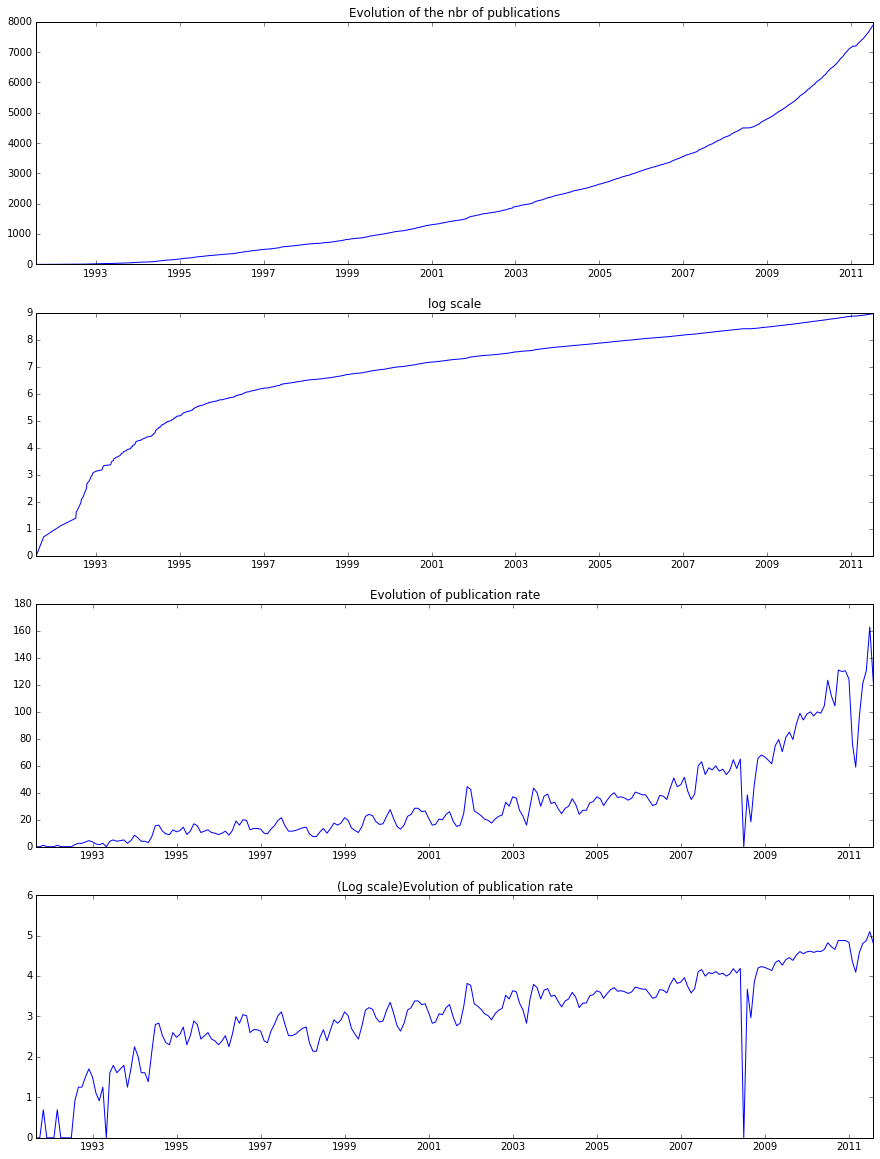

In [236]:
pd_nbr_publication_evolution = pd.DataFrame(index = lst_date, data = np.arange(len(lst_date)))

nplot = 4
fig, ax = plt.subplots(nplot, figsize=(15, 5 * nplot))
cnt = 0

ax[cnt].plot(pd_nbr_publication_evolution)
ax[cnt].set_title("Evolution of the nbr of publications")
cnt += 1

ax[cnt].plot(np.log(1 + pd_nbr_publication_evolution))
ax[cnt].set_title("log scale")
cnt += 1

# Publication tate per month (or change M to something)
pd_month_rate = pd_nbr_publication_evolution.resample('M').mean().dropna().diff().resample('M').mean().fillna(0)
ax[cnt].plot(pd_month_rate)
ax[cnt].set_title("Evolution of publication rate")
cnt += 1
# log scale
ax[cnt].plot(np.log(1 + pd_month_rate))
ax[cnt].set_title("(Log scale)Evolution of publication rate")



### Who are the autors 

In [239]:
def add_to_dic(lst, dic) :
    
    def add_entry(item) :
        if item in dic:
            dic[item] += 1
        else:
            dic[item] = 1
            
    list(map(add_entry, lst))
    

In [240]:
STEP_SIZE = 100
nsteps = int(nmax/STEP_SIZE) + 1

print("Number of steps to perform: {}; size: {}".format(nsteps, STEP_SIZE))

dic_authors = {}

for i in range(nsteps) :
    st = STEP_SIZE * i
    en = min(STEP_SIZE * (i+1), nmax)
    delta = en - st
    if delta <= 0 :
        break
    
    print("Step {}".format(i))
    my_url = create_query("machine learning", max_results = delta, start = st, sortOrder="ascending")
    get_response = requests.get(my_url)
    Result = get_response.content.decode() 
    
    add_to_dic(get_author(re_author.findall(Result)), dic_authors)
    
print("Finished !")

Number of steps to perform: 81; size: 100
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Finished !


In [251]:
pd_authors = pd.DataFrame.from_dict(dic_authors, orient='index')
pd_authors.columns = ["Count"]
pd_authors = pd_authors.sort_values(by="Count", ascending=False)
pd_authors

,Count
Marcus Hutter,72
Vladimir Vovk,23
Uwe Aickelin,20
John Langford,19
Masato Okada,18
James P. Crutchfield,17
Andras Lorincz,17
Ajith Abraham,17
J. G. Learned,16
Juergen Schmidhuber,16


In [269]:
max_publication = pd_authors.Count.max()
print("Max publication: {}".format(max_publication))

Max publication: 72


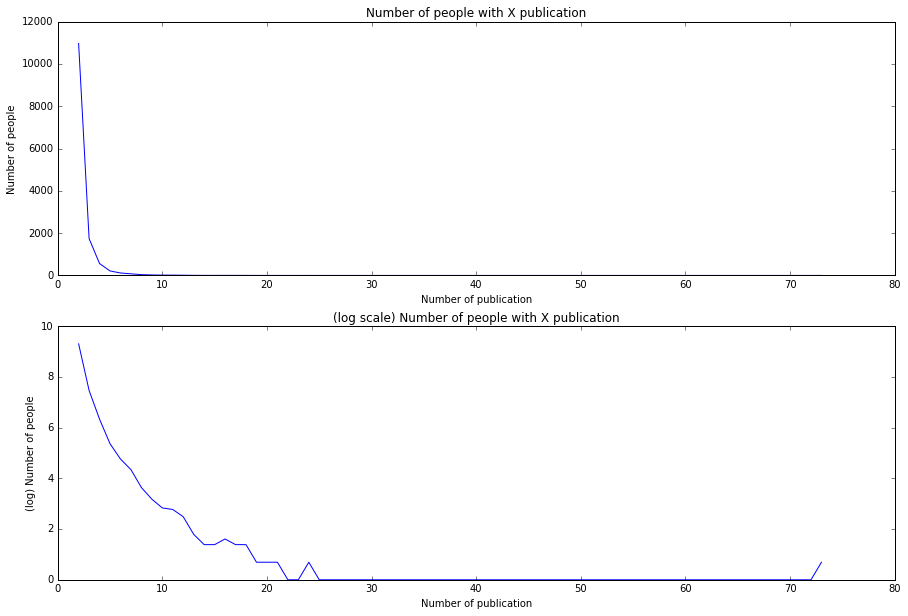

In [283]:
Y, X = np.histogram(pd_authors.Count, max_publication, (1, max_publication + 1))

fig, ax = plt.subplots(2, figsize= (15, 10))
ax[0].plot(X[1:], Y)
ax[1].plot(X[1:], np.log(1+Y))

ax[0].set_title("Number of people with X publication")
ax[0].set_ylabel("Number of people")
ax[0].set_xlabel("Number of publications
                 ")

ax[1].set_title("(log scale) Number of people with X publication")
ax[1].set_ylabel("(log) Number of people")
ax[1].set_xlabel("Number of publications")



### What are the keywords 

In [294]:
def add_to_dic_set(lst, dic):
    for w in set(lst) :
        if w in dic:
            dic[w] += lst.count(w)
        else :
            dic[w] = lst.count(w)
        

In [314]:
STEP_SIZE = 100
nsteps = int(nmax/STEP_SIZE) + 1

print("Number of steps to perform: {}; size: {}".format(nsteps, STEP_SIZE))

dic_title = {}

for i in range(nsteps) :
    st = STEP_SIZE * i
    en = min(STEP_SIZE * (i+1), nmax)
    delta = en - st
    if delta <= 0 :
        break
    
    print("Step {}".format(i))
    my_url = create_query("machine learning", max_results = delta, start = st, sortOrder="ascending")
    get_response = requests.get(my_url)
    Result = get_response.content.decode() 
    
    lst_title_words = [] 
    # sorry for the unlisibility, there may be a clever way to do that
    # extract all the title words and put it into a dic for counting
    _ = list(map(lambda x: lst_title_words.extend(x.lower().split()), get_title(re_title.findall(Result))))
    add_to_dic_set(lst_title_words, dic_title)
    
print("Finished !")

Number of steps to perform: 81; size: 100
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Finished !


In [319]:
pd_title = pd.DataFrame.from_dict(dic_title, orient='index')
pd_title.columns = ["Count"]
pd_title = pd_title.sort_values(by="Count", ascending=False)

# remove particules
filtering = pd_title.index.map(len) > 3

particules = pd_title[filtering == False]

pd_title[filtering]

,Count
learning,416
quantum,258
with,255
from,162
machine,148
using,133
machines,113
networks,104
model,96
data,92


In [326]:
max_word = pd_title.Count.max()
print(max_word)

992


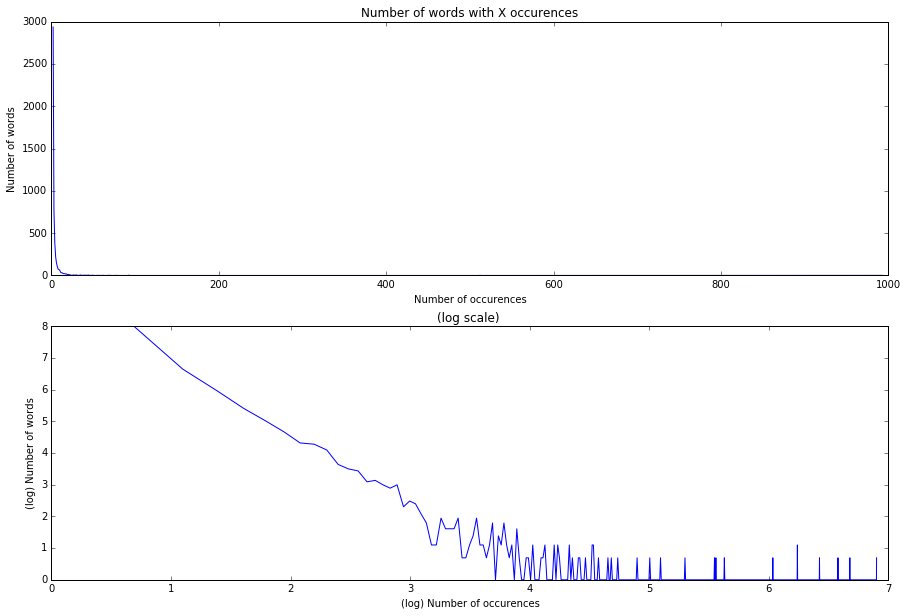

In [325]:
Y, X = np.histogram(pd_title.Count, max_word, (1, max_word + 1))

fig, ax = plt.subplots(2, figsize= (15, 10))
ax[0].plot(X[1:], Y)
ax[1].plot(np.log(X[1:]), np.log(1+Y))

ax[0].set_title("Number of words with X occurences")
ax[0].set_ylabel("Number of words")
ax[0].set_xlabel("Number of occurences")

ax[1].set_title("(log scale) ")
ax[1].set_ylabel("(log) Number of words")
ax[1].set_xlabel("(log) Number of occurences")


-----------------

### TF-IDF on summary

Make a dic for each word, with list value of frequency

In [385]:
def word_frequency(txt, dic) :
    """
    Normal frequency, no special normalisation
    """
    
    lst_words = txt.lower()
    while '{' in lst_words :
        c1 = lst_words.find("{")
        c2 = lst_words.find("}")
        if c2 > c1 :
            lst_words = lst_words[:c1] + lst_words[c2+1:]
        elif c2 == -1 :
            # please, no typo
            lst_words = lst_words[:c1] + lst_words[c1+1:]
        else : 
            lst_words = lst_words[:c2] + lst_words[c2+1:]

    for m in """,;:!'"?./_()[]$&\\+1234567890~`""" :
        lst_words = lst_words.replace(m, " ")
    lst_words = lst_words.split()
    c = len(lst_words)
    
    for w in set(lst_words) :
        cw = lst_words.count(w)/c
        if w in dic:
            dic[w].append(cw)
        else :
            dic[w] = [cw]
    
    

In [386]:
STEP_SIZE = 100
nsteps = int(nmax/STEP_SIZE) + 1

print("Number of steps to perform: {}; size: {}".format(nsteps, STEP_SIZE))

dic_summary = {}

for i in range(nsteps) :
    st = STEP_SIZE * i
    en = min(STEP_SIZE * (i+1), nmax)
    delta = en - st
    if delta <= 0 :
        break
    
    print("Step {}".format(i))
    my_url = create_query("machine learning", max_results = delta, start = st, sortOrder="ascending")
    get_response = requests.get(my_url)
    Result = get_response.content.decode() 
    
    list(map(lambda x: word_frequency(x, dic_summary), extract_summary(Result)))
    
    
print("Finished !")

Number of steps to perform: 81; size: 100
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Finished !


In [387]:
DF = np.log(list(map(lambda x: nmax / len(dic_summary[x]), dic_summary)))
ME = np.array(list(map(lambda x: np.mean(dic_summary[x]), dic_summary)))
names = dic_summary.keys()

In [388]:
pd_title = pd.DataFrame(index=names, data = np.array([DF, ME, DF * ME]).T, columns=["IDF","MFreq","TFIDF"])

pd_title = pd_title.sort_values(by="TFIDF", ascending=False)

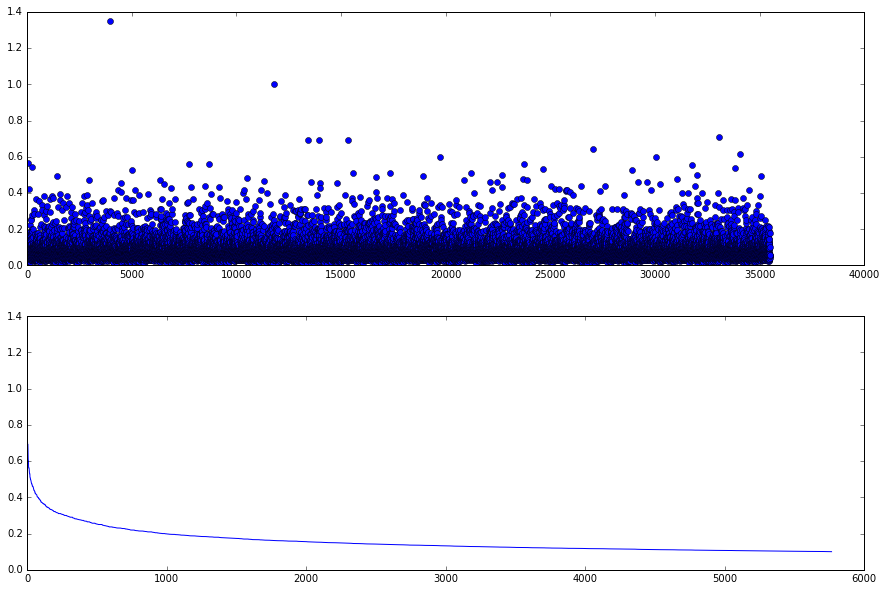

In [389]:
fig, ax = plt.subplots(2, figsize=(15,10))
ax[0].plot(DF * ME, 'o')
ax[1].plot((pd_title.TFIDF[pd_title.TFIDF > 0.1].data))

In [390]:
pd_title

,IDF,MFreq,TFIDF
retracted,8.306102,0.162500,1.349742
fibonacci,8.999249,0.111111,0.999917
quasiconvex,8.999249,0.078947,0.710467
n*n,8.999249,0.076923,0.692250
non-correctness,8.999249,0.076923,0.692250
-|,8.999249,0.076923,0.692250
block-l,8.999249,0.071429,0.642803
please,8.306102,0.074286,0.617025
semotics,8.999249,0.066667,0.599950
semiotic,8.999249,0.066667,0.599950


In [391]:
pd_title[pd_title.TFIDF > 0.1]

,IDF,MFreq,TFIDF
retracted,8.306102,0.162500,1.349742
fibonacci,8.999249,0.111111,0.999917
quasiconvex,8.999249,0.078947,0.710467
n*n,8.999249,0.076923,0.692250
non-correctness,8.999249,0.076923,0.692250
-|,8.999249,0.076923,0.692250
block-l,8.999249,0.071429,0.642803
please,8.306102,0.074286,0.617025
semotics,8.999249,0.066667,0.599950
semiotic,8.999249,0.066667,0.599950
